[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO Object Detection on a Custom Dataset

---


## Environment setup

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()  # charge .env dans os.environ
api_key = os.getenv("ROBOFLOW_API_KEY")

### Check GPU availability

In [2]:
!nvidia-smi

Sun Jun 29 12:22:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.72                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060 3GB    On  |   00000000:01:00.0  On |                  N/A |
| 26%   65C    P8             11W /  120W |    2276MiB /   3072MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/home/jovyan/notebooks


### Install dependencies

In [4]:
!pip install roboflow supervision opencv-python ultralytics

Defaulting to user installation because normal site-packages is not writeable


### Download example data


In [5]:
!wget https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true

--2025-06-29 12:22:09--  https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg [following]
--2025-06-29 12:22:10--  https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg [following]
--2025-06-29 12:22:10--  https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (

## Run inference


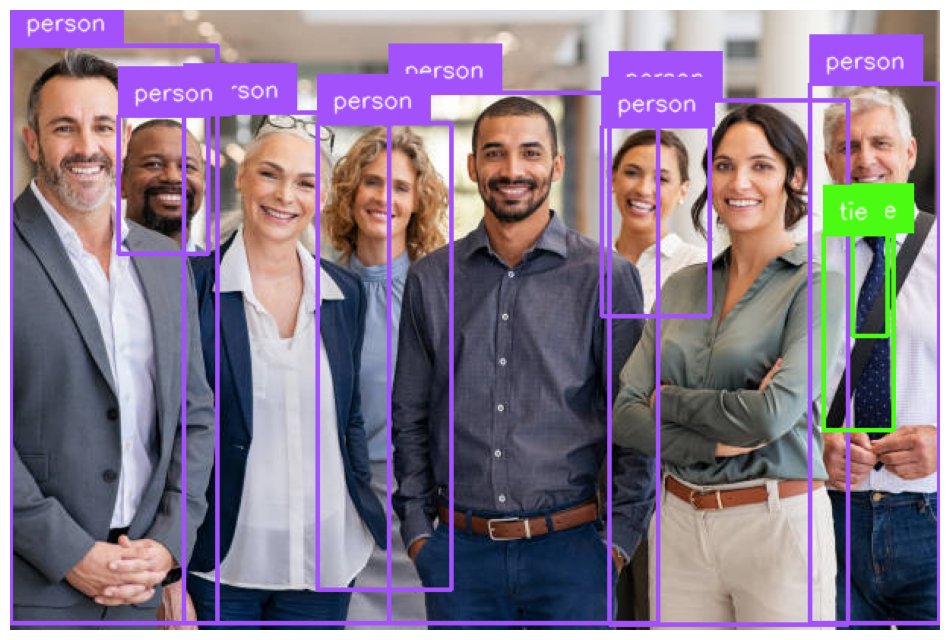

In [6]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/example.jpg?raw=true"
image = cv2.imread(image_path)

model = YOLO('yolov8s.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [7]:
!pip install roboflow


import getpass
from roboflow import Roboflow

api_key = getpass.getpass("Entre ta clé API Roboflow (masquée) : ")

rf = Roboflow(api_key=api_key)
project = rf.workspace("mohamed-traore-2ekkp").project("face-detection-mik1i")
version = project.version(27)
dataset = version.download("yolov8")

Defaulting to user installation because normal site-packages is not writeable


Entre ta clé API Roboflow (masquée) :  ········


loading Roboflow workspace...
loading Roboflow project...


In [8]:
!ls {dataset.location}

README.dataset.txt  README.roboflow.txt  data.yaml  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [9]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [10]:
!cat {dataset.location}/data.yaml

names:
- face
nc: 1
roboflow:
  license: CC BY 4.0
-e test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLO model


In [11]:
from ultralytics import YOLO

model = YOLO('yolov8s')

results = model.train(data=f'{dataset.location}/data.yaml',  project='/home/jovyan/yolo-training', epochs=100, batch=4, patience=0, save_period=5, save=True, workers=2)

New https://pypi.org/project/ultralytics/8.3.160 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.157 🚀 Python-3.10.18 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3072MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/jovyan/notebooks/Face-Detection-27/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train19, nb

train: Scanning /home/jovyan/notebooks/Face-Detection-27/train/labels... 132 images, 426 backgrounds, 0 corrupt: 100% 549/549 [00:00<00:00, 961.58it/s]

train: New cache created: /home/jovyan/notebooks/Face-Detection-27/train/labels.cache


val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 74.1±35.5 MB/s, size: 88.6 KB)


val: Scanning /home/jovyan/notebooks/Face-Detection-27/valid/labels.cache... 38 images, 1 backgrounds, 0 corrupt: 100% 38/38 [00:00<?, ?it/s]


Plotting labels to /home/jovyan/yolo-training/train19/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /home/jovyan/yolo-training/train19
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.25G      1.062      12.25      1.166          0        640: 100% 138/138 [00:55<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.71it/s]

                   all         38         49      0.491      0.612      0.495      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.29G      1.457      2.798       1.48          0        640: 100% 138/138 [01:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.35it/s]

                   all         38         49    0.00845     0.0408     0.0036    0.00138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.49G      1.693      2.331      1.753          0        640: 100% 138/138 [00:51<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.51it/s]

                   all         38         49      0.616      0.551      0.601      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.52G       1.71      2.386      1.713          1        640: 100% 138/138 [00:51<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.14it/s]

                   all         38         49     0.0438      0.327     0.0377     0.0136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       1.4G      1.606      1.799       1.65          0        640: 100% 138/138 [00:50<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.91it/s]

                   all         38         49      0.678      0.643      0.669      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.44G      1.836      1.922      1.818          0        640: 100% 138/138 [00:55<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.95it/s]

                   all         38         49      0.718      0.633      0.751      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.47G      1.535      1.705      1.596          0        640: 100% 138/138 [00:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.64it/s]

                   all         38         49      0.847      0.789      0.851      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.51G      1.527      1.451      1.581          1        640: 100% 138/138 [00:55<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.47it/s]

                   all         38         49    0.00212      0.408    0.00151   0.000444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       1.4G      1.445      1.516      1.534          0        640: 100% 138/138 [00:46<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.38it/s]

                   all         38         49      0.683      0.653      0.706      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.43G      1.447      1.327      1.568          0        640: 100% 138/138 [00:56<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.39it/s]

                   all         38         49      0.817      0.857      0.866      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.47G      1.461      1.388      1.552          0        640: 100% 138/138 [00:53<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.67it/s]

                   all         38         49      0.867      0.816      0.851      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.49G      1.456      1.477      1.564          1        640: 100% 138/138 [00:49<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.72it/s]

                   all         38         49      0.859      0.714      0.868      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.54G      1.368      1.309      1.475          4        640: 100% 138/138 [00:52<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.97it/s]

                   all         38         49      0.848      0.799      0.853      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.42G      1.307      1.225      1.447          0        640: 100% 138/138 [00:51<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.29it/s]

                   all         38         49      0.928      0.857       0.91      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.45G      1.516      1.414       1.65          2        640: 100% 138/138 [00:51<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.80it/s]

                   all         38         49      0.712      0.796      0.849      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.48G      1.378      1.409      1.519          0        640: 100% 138/138 [00:51<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.41it/s]

                   all         38         49      0.742      0.837      0.856      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.52G      1.449      1.448      1.598          0        640: 100% 138/138 [00:53<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.26it/s]

                   all         38         49       0.92      0.857      0.904      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.41G      1.319        1.2       1.48          0        640: 100% 138/138 [00:51<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.88it/s]

                   all         38         49       0.89      0.837      0.879      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.44G      1.419      1.321      1.545          2        640: 100% 138/138 [00:57<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.22it/s]

                   all         38         49      0.896      0.898       0.91      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.47G      1.229      1.125      1.376          0        640: 100% 138/138 [00:49<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.60it/s]

                   all         38         49      0.812      0.898      0.916      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.52G       1.15      1.163      1.295          0        640: 100% 138/138 [00:55<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.96it/s]

                   all         38         49      0.915      0.857      0.921      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.41G      1.215      1.145      1.335          0        640: 100% 138/138 [00:51<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.96it/s]

                   all         38         49      0.944      0.878      0.919      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.44G      1.133      1.132      1.293          0        640: 100% 138/138 [00:53<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.88it/s]

                   all         38         49      0.913      0.854      0.891        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.48G       1.27      1.119      1.388          0        640: 100% 138/138 [00:54<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.81it/s]

                   all         38         49      0.914      0.837       0.91      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.52G      1.238      1.108      1.401          2        640: 100% 138/138 [00:48<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.76it/s]


                   all         38         49      0.891      0.776      0.881      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.38G      1.168       1.07      1.301          1        640: 100% 138/138 [00:55<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.35it/s]

                   all         38         49      0.902      0.898      0.922      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.42G      1.223       1.16      1.448          0        640: 100% 138/138 [00:51<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.47it/s]

                   all         38         49      0.874      0.878      0.902      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.44G      1.039     0.9643      1.235          0        640: 100% 138/138 [00:54<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.06it/s]

                   all         38         49      0.898      0.896      0.934      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.49G        1.2      1.048      1.376          1        640: 100% 138/138 [00:50<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.23it/s]

                   all         38         49      0.934      0.837      0.907      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.53G      1.094      1.063      1.283          1        640: 100% 138/138 [00:55<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.82it/s]

                   all         38         49      0.899      0.904      0.925      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.42G        1.1      1.034       1.27          0        640: 100% 138/138 [00:51<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.20it/s]

                   all         38         49      0.936      0.892      0.923       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.44G      1.154      1.064       1.35          0        640: 100% 138/138 [00:53<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.39it/s]

                   all         38         49      0.944      0.898      0.937      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.47G      1.115     0.9999      1.327          0        640: 100% 138/138 [00:56<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.88it/s]

                   all         38         49      0.918      0.878      0.914      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.51G      1.112      1.042      1.267          1        640: 100% 138/138 [00:47<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.86it/s]

                   all         38         49      0.924      0.857      0.906      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.41G      1.167     0.9939      1.357          1        640: 100% 138/138 [00:57<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.08it/s]


                   all         38         49      0.949      0.898      0.936      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.43G      1.013     0.9036      1.186          0        640: 100% 138/138 [00:49<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.36it/s]

                   all         38         49      0.977      0.869      0.924      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.48G      1.044     0.9205      1.269          1        640: 100% 138/138 [00:51<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.31it/s]

                   all         38         49      0.973      0.898      0.933       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.52G     0.9491     0.8089      1.109          0        640: 100% 138/138 [00:54<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.62it/s]

                   all         38         49      0.957      0.916      0.936       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       1.4G       1.11     0.9934      1.315          1        640: 100% 138/138 [00:51<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.52it/s]

                   all         38         49      0.955      0.898      0.947      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.44G      1.014     0.9131      1.225          0        640: 100% 138/138 [00:57<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.03it/s]

                   all         38         49      0.956      0.939      0.947      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.48G      1.006     0.9801      1.176          0        640: 100% 138/138 [00:46<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.28it/s]

                   all         38         49      0.945      0.918      0.948      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.51G      1.008     0.9103      1.226          2        640: 100% 138/138 [00:58<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.25it/s]

                   all         38         49      0.957      0.913      0.952       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.39G      1.109     0.9752      1.286          0        640: 100% 138/138 [00:53<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.03it/s]

                   all         38         49      0.938      0.939       0.94      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.42G      1.014      0.945       1.21          1        640: 100% 138/138 [00:51<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.39it/s]

                   all         38         49       0.95      0.898      0.943      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.47G      1.028     0.8889       1.24          0        640: 100% 138/138 [00:56<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.88it/s]

                   all         38         49      0.953      0.898      0.935      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       1.5G     0.9764     0.8354      1.187          0        640: 100% 138/138 [00:51<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.40it/s]

                   all         38         49      0.935       0.88      0.929       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.39G     0.9739     0.8456      1.196          1        640: 100% 138/138 [01:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.70it/s]

                   all         38         49      0.957      0.904      0.937      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.43G      1.067     0.9127      1.294          0        640: 100% 138/138 [00:48<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.50it/s]

                   all         38         49      0.956       0.89      0.927      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.46G      1.007     0.9046      1.286          1        640: 100% 138/138 [00:55<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.21it/s]

                   all         38         49      0.968      0.898      0.946      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       1.5G      1.002     0.8292      1.238          2        640: 100% 138/138 [00:55<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.12it/s]

                   all         38         49      0.959      0.954      0.964      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       1.4G     0.9742     0.8565      1.206          0        640: 100% 138/138 [00:49<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.71it/s]

                   all         38         49      0.977      0.898      0.933      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.42G     0.9568     0.8327       1.19          1        640: 100% 138/138 [00:58<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.43it/s]

                   all         38         49      0.952      0.898      0.943      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.47G     0.9226     0.7865      1.206          0        640: 100% 138/138 [00:50<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.81it/s]

                   all         38         49      0.973      0.898      0.948      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.51G     0.8939     0.7652      1.119          2        640: 100% 138/138 [00:53<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.06it/s]

                   all         38         49      0.972      0.898      0.965      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.41G      1.015      0.824      1.312          2        640: 100% 138/138 [00:55<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.70it/s]

                   all         38         49      0.973      0.898      0.966      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.45G     0.9701     0.7849       1.19          0        640: 100% 138/138 [00:52<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.20it/s]

                   all         38         49      0.973      0.898      0.958      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.49G     0.9294     0.8139      1.152          0        640: 100% 138/138 [00:58<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.75it/s]

                   all         38         49      0.974      0.898      0.962      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.52G     0.9652     0.8355      1.178          0        640: 100% 138/138 [00:48<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.49it/s]

                   all         38         49      0.976      0.898      0.961      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.42G     0.9344     0.8184      1.205          0        640: 100% 138/138 [00:55<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.19it/s]

                   all         38         49      0.948      0.898      0.954       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.44G     0.9568     0.8381      1.223          0        640: 100% 138/138 [00:56<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.58it/s]

                   all         38         49      0.953      0.878      0.958      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.48G     0.8865     0.7945      1.133          0        640: 100% 138/138 [00:48<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.18it/s]

                   all         38         49      0.939      0.944      0.976      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.52G     0.9551     0.8409      1.217          1        640: 100% 138/138 [00:58<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.02it/s]

                   all         38         49      0.957      0.914       0.97      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.39G     0.9339     0.7995      1.227          0        640: 100% 138/138 [00:51<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.56it/s]

                   all         38         49      0.958      0.937      0.975      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.43G     0.9248     0.7597      1.211          1        640: 100% 138/138 [00:52<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:03<00:00,  1.29it/s]

                   all         38         49      0.971      0.918      0.968      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.46G     0.9072     0.7752      1.157          1        640: 100% 138/138 [00:54<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.18it/s]

                   all         38         49       0.99      0.898      0.969      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       1.5G     0.9372     0.7996      1.193          0        640: 100% 138/138 [00:51<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.79it/s]

                   all         38         49      0.984      0.898       0.98      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.53G     0.8249     0.7001      1.021          1        640: 100% 138/138 [00:58<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.30it/s]

                   all         38         49      0.972      0.918      0.971      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.42G     0.9068     0.7909      1.206          0        640: 100% 138/138 [00:53<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.49it/s]

                   all         38         49          1      0.937      0.981      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.44G     0.9135     0.7562        1.2          0        640: 100% 138/138 [00:50<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.66it/s]

                   all         38         49      0.981      0.918      0.971      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.48G     0.9308     0.8053      1.182          0        640: 100% 138/138 [00:57<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.32it/s]

                   all         38         49      0.976      0.918      0.967      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.52G     0.8974     0.7713      1.169          1        640: 100% 138/138 [00:47<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.69it/s]

                   all         38         49       0.97      0.918      0.967      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       1.4G     0.8441     0.6941      1.117          0        640: 100% 138/138 [00:59<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.60it/s]

                   all         38         49      0.959      0.918      0.978      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.44G     0.8156     0.7161      1.109          0        640: 100% 138/138 [00:55<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.10it/s]

                   all         38         49      0.987      0.918      0.979      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.48G     0.8214     0.7033      1.056          0        640: 100% 138/138 [00:50<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.05it/s]

                   all         38         49      0.978      0.918      0.982      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.51G     0.8138     0.7132      1.091          0        640: 100% 138/138 [00:55<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.70it/s]

                   all         38         49      0.979      0.935       0.98       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       1.4G     0.7517     0.6522      1.021          0        640: 100% 138/138 [00:53<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.76it/s]

                   all         38         49      0.974      0.939      0.983       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.44G     0.8274     0.6876      1.117          0        640: 100% 138/138 [00:53<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.96it/s]

                   all         38         49      0.979      0.938      0.984      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.48G     0.8971     0.6999      1.199          0        640: 100% 138/138 [00:58<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  2.64it/s]

                   all         38         49      0.977      0.959      0.984      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.52G     0.7544     0.6904      1.031          0        640: 100% 138/138 [00:47<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.76it/s]

                   all         38         49      0.971      0.939      0.975      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.41G     0.8166      0.695      1.113          3        640: 100% 138/138 [01:06<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.56it/s]

                   all         38         49      0.979      0.939      0.977      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.44G     0.8767     0.6751      1.145          0        640: 100% 138/138 [01:04<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.85it/s]

                   all         38         49      0.987      0.939      0.974      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.48G     0.8083     0.6692      1.108          2        640: 100% 138/138 [01:03<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.26it/s]

                   all         38         49      0.955      0.939      0.975      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.52G     0.8556     0.7064      1.147          1        640: 100% 138/138 [01:15<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.67it/s]

                   all         38         49      0.992      0.939      0.979      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.38G     0.8215     0.6362      1.091          1        640: 100% 138/138 [00:51<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.17it/s]

                   all         38         49      0.988      0.939      0.974      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.42G     0.7968     0.6609      1.131          0        640: 100% 138/138 [01:11<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  2.83it/s]

                   all         38         49      0.967      0.939      0.979      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.46G     0.7975      0.643      1.088          0        640: 100% 138/138 [01:15<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.64it/s]

                   all         38         49      0.973      0.939      0.976      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       1.5G     0.7657     0.6344      1.084          0        640: 100% 138/138 [00:51<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.43it/s]

                   all         38         49      0.954      0.959      0.979      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.53G     0.7903     0.6461      1.108          0        640: 100% 138/138 [00:56<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.66it/s]

                   all         38         49      0.937      0.959      0.985      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.41G     0.8269     0.6979      1.163          1        640: 100% 138/138 [00:56<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.98it/s]

                   all         38         49      0.973      0.959      0.988      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.43G     0.7499     0.6264      1.054          0        640: 100% 138/138 [00:53<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.71it/s]

                   all         38         49      0.976      0.959      0.986      0.718


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.47G     0.5634     0.4505      0.845          0        640: 100% 138/138 [00:58<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.52it/s]


                   all         38         49      0.975      0.939      0.978      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.49G     0.5178      0.433     0.8121          1        640: 100% 138/138 [00:49<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:00<00:00,  5.46it/s]

                   all         38         49      0.973      0.939      0.975       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.54G     0.5138     0.4343     0.8489          0        640: 100% 138/138 [00:50<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.92it/s]


                   all         38         49      0.977      0.939      0.975      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       1.4G     0.4595     0.3979     0.7522          0        640: 100% 138/138 [00:56<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.64it/s]

                   all         38         49      0.966      0.918      0.983      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.43G     0.4861     0.3971     0.7737          0        640: 100% 138/138 [00:49<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.40it/s]

                   all         38         49      0.974      0.939      0.985      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.47G     0.4949     0.3924     0.8222          1        640: 100% 138/138 [00:51<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.21it/s]

                   all         38         49      0.976      0.939      0.986      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.51G     0.5017     0.4039     0.8048          0        640: 100% 138/138 [00:58<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.90it/s]

                   all         38         49      0.975      0.939      0.982      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.41G     0.5092     0.4147     0.8181          0        640: 100% 138/138 [00:49<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  4.33it/s]

                   all         38         49      0.973      0.939      0.984      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.45G     0.4817     0.4059      0.779          0        640: 100% 138/138 [00:53<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.43it/s]


                   all         38         49      0.954      0.939      0.983      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.47G     0.5164     0.4223     0.8117          0        640: 100% 138/138 [00:57<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.35it/s]

                   all         38         49      0.974      0.939      0.986      0.735



100 epochs completed in 1.568 hours.
Optimizer stripped from /home/jovyan/yolo-training/train19/weights/last.pt, 22.5MB
Optimizer stripped from /home/jovyan/yolo-training/train19/weights/best.pt, 22.5MB

Validating /home/jovyan/yolo-training/train19/weights/best.pt...
Ultralytics 8.3.157 🚀 Python-3.10.18 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3072MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:01<00:00,  3.43it/s]


                   all         38         49      0.974      0.939      0.986      0.735
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 11.2ms postprocess per image
Results saved to /home/jovyan/yolo-training/train19


## Evaluate fine-tuned YOLOv12 model

In [12]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls /home/jovyan/yolo-training/train19

F1_curve.png			 labels_correlogram.jpg  train_batch2.jpg
PR_curve.png			 results.csv		 val_batch0_labels.jpg
P_curve.png			 results.png		 val_batch0_pred.jpg
R_curve.png			 train_batch0.jpg	 val_batch1_labels.jpg
args.yaml			 train_batch1.jpg	 val_batch1_pred.jpg
confusion_matrix.png		 train_batch12420.jpg	 val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch12421.jpg	 val_batch2_pred.jpg
labels.jpg			 train_batch12422.jpg	 weights


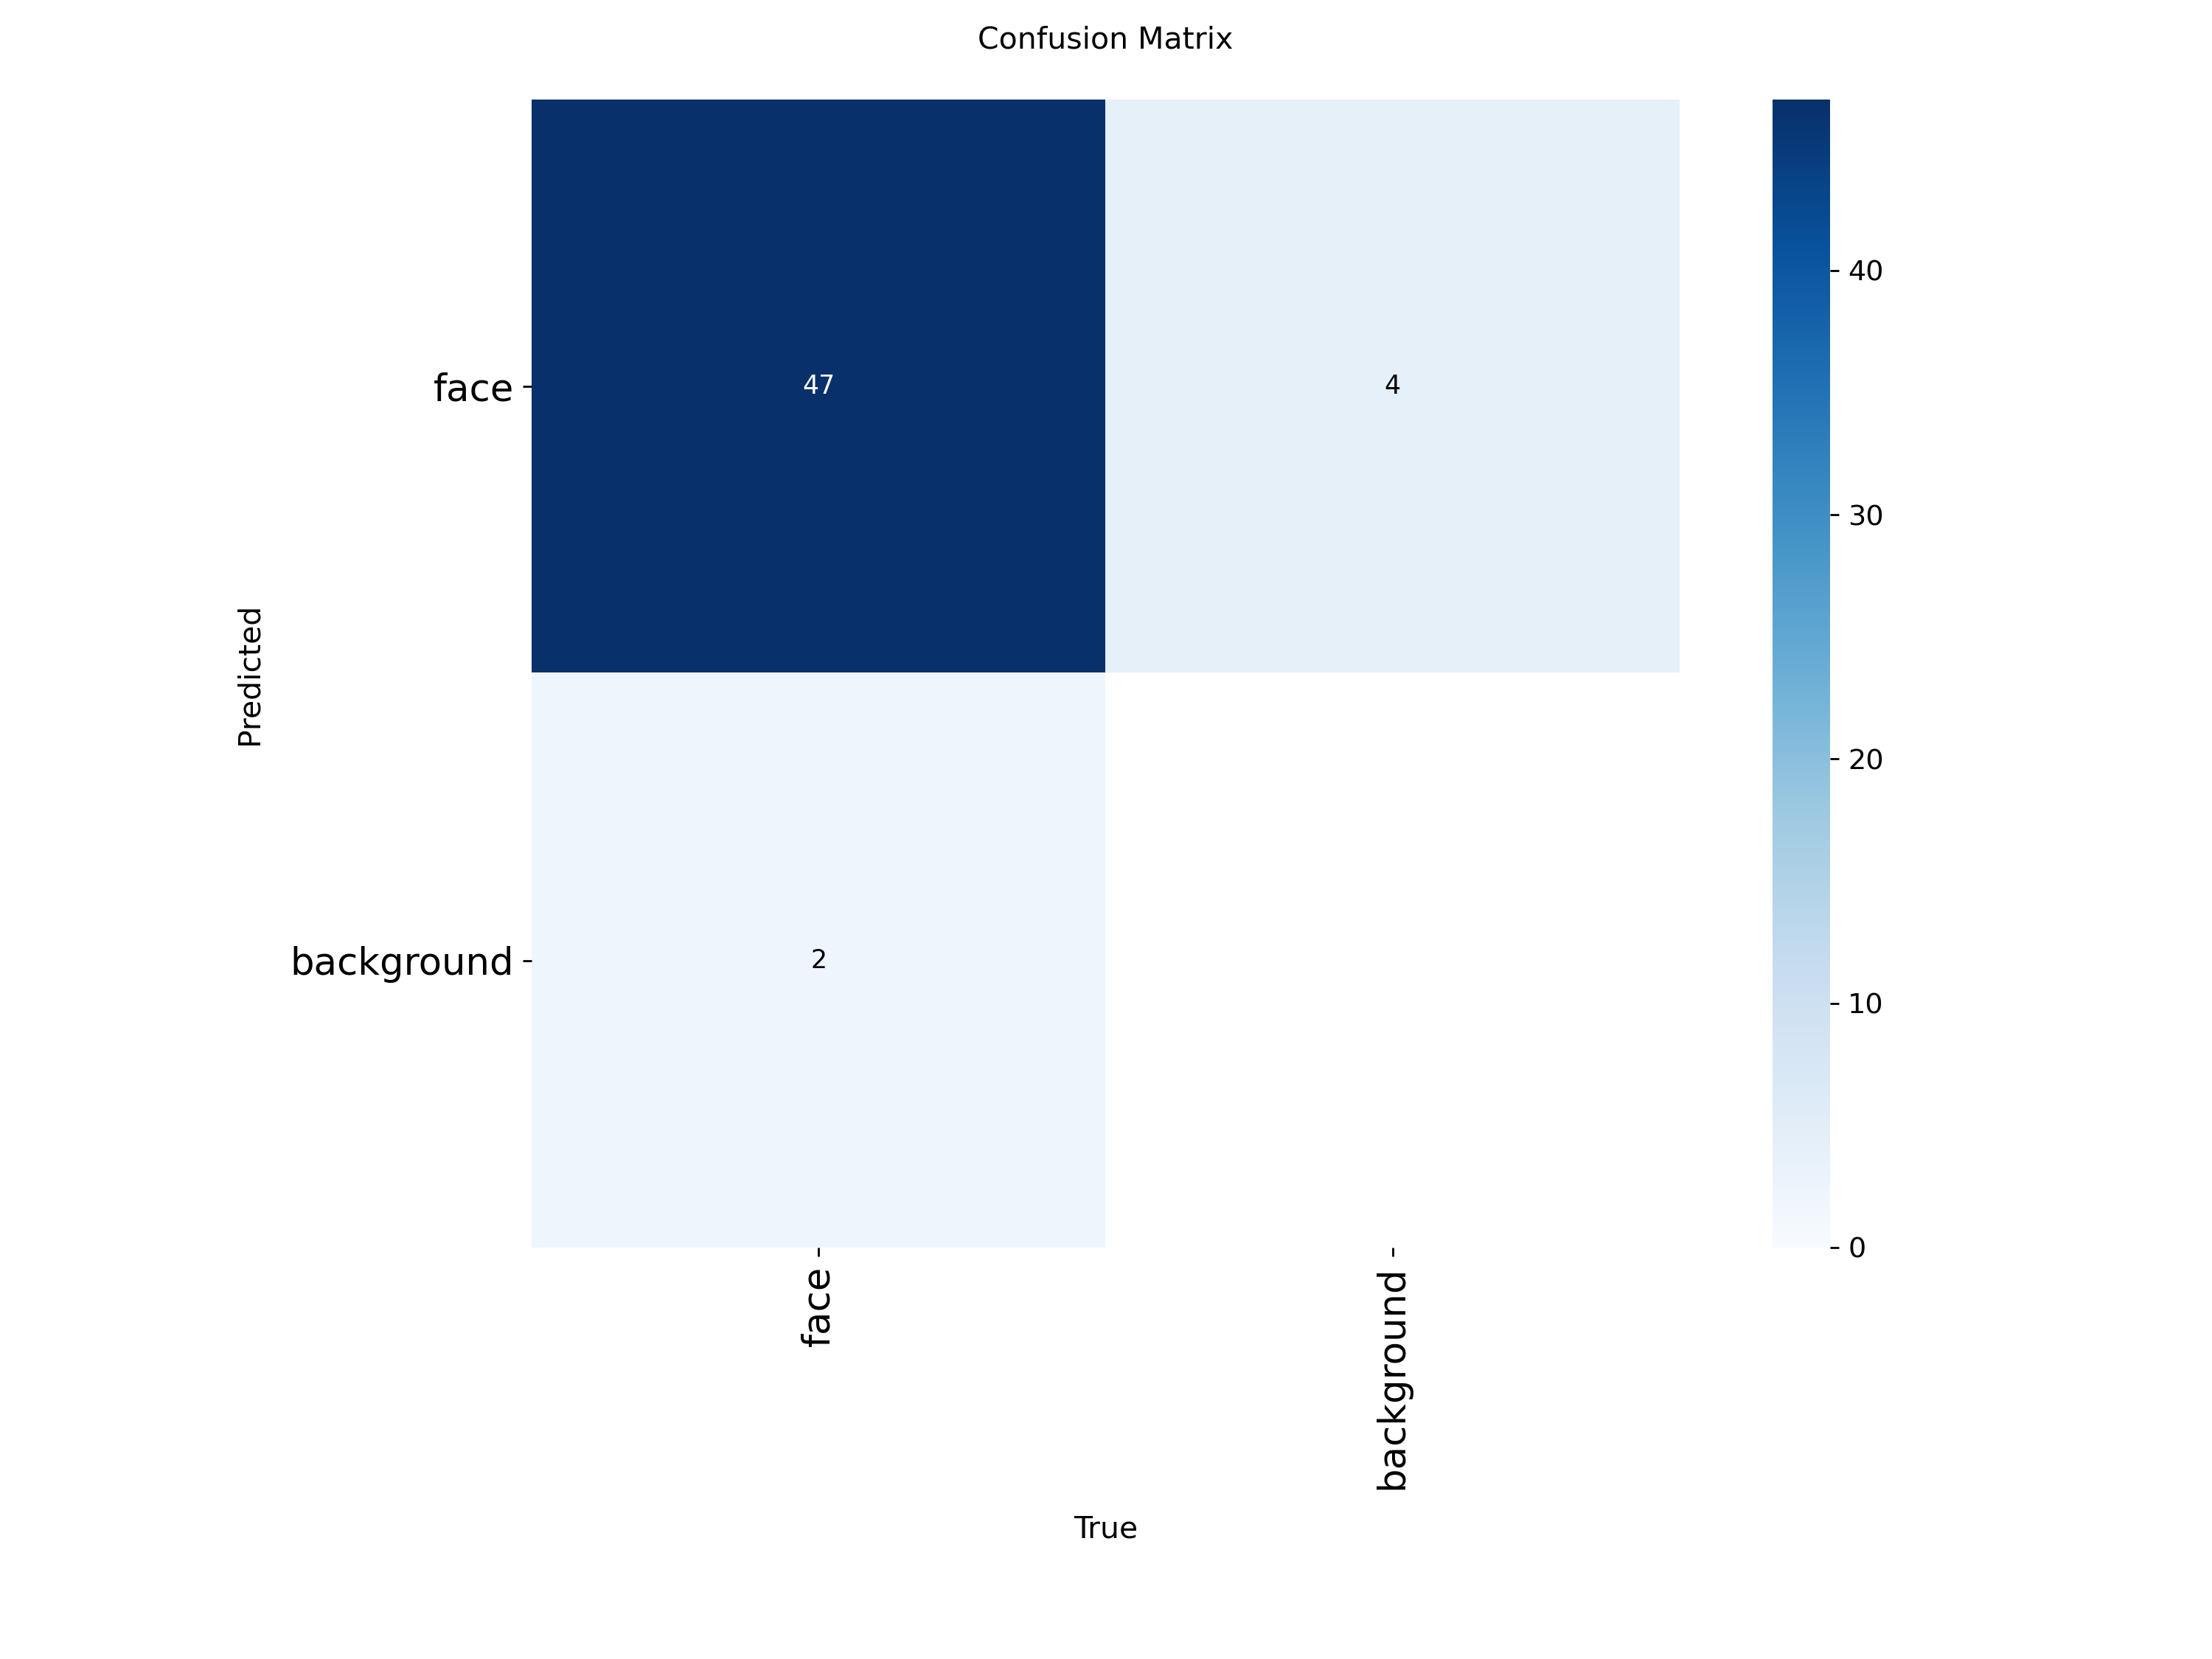

In [13]:
from IPython.display import Image

Image(filename=f'/home/jovyan/yolo-training/train19/confusion_matrix.png', width=1000)

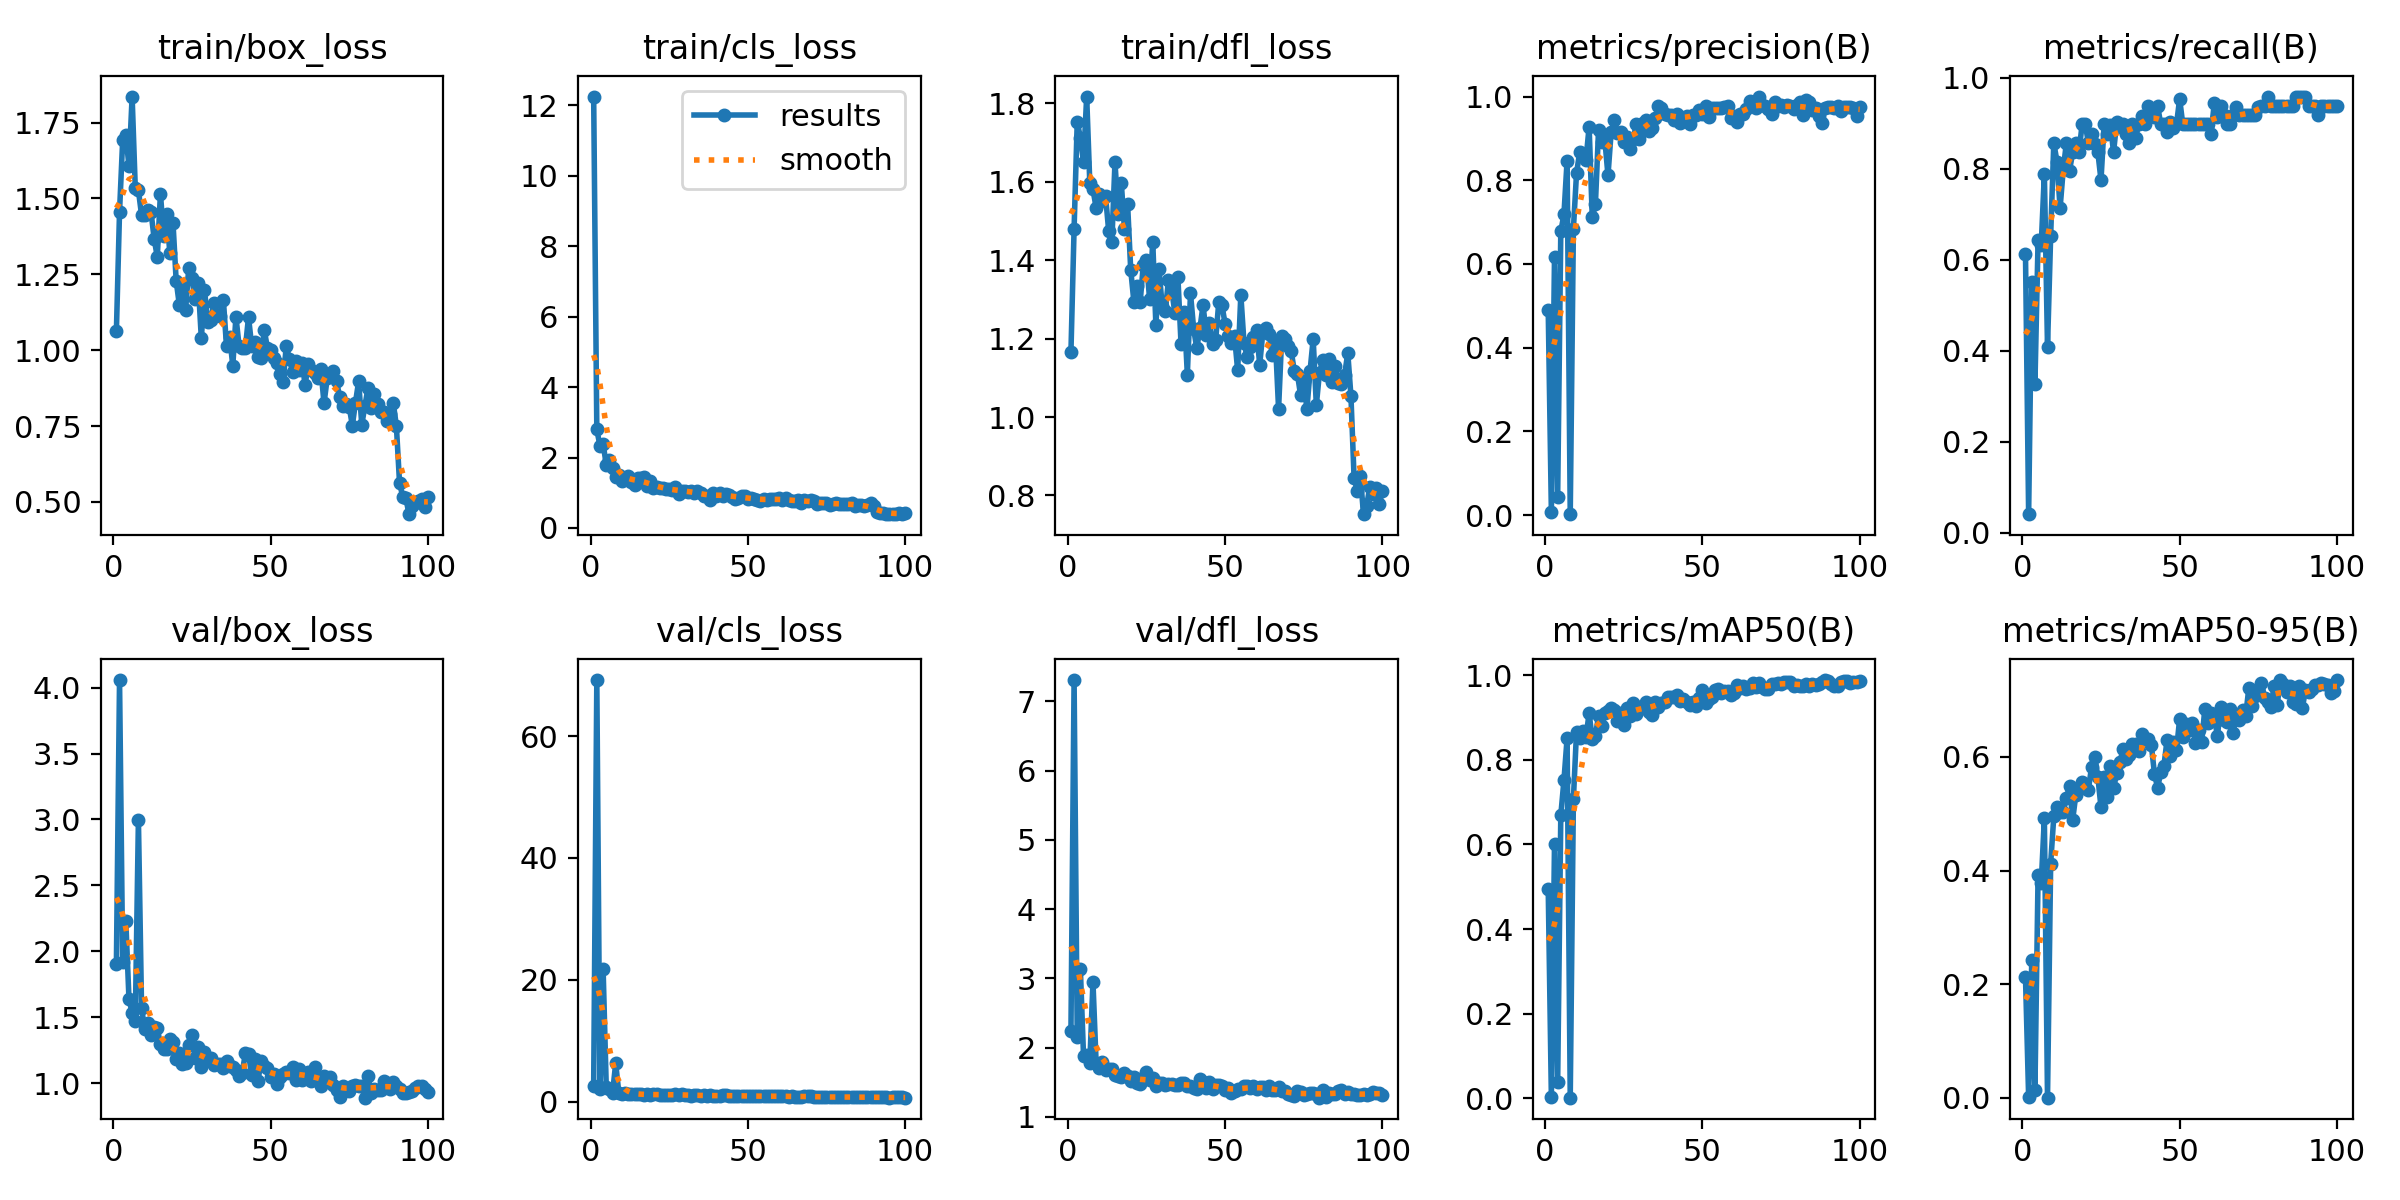

In [14]:
from IPython.display import Image

Image(filename=f'/home/jovyan/yolo-training/train19/results.png', width=1000)

In [15]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['face']

In [16]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/home/jovyan/yolo-training/train19/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [17]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.7037503063564912
mAP 50 0.9999999999999999
mAP 75 0.7774984555814699


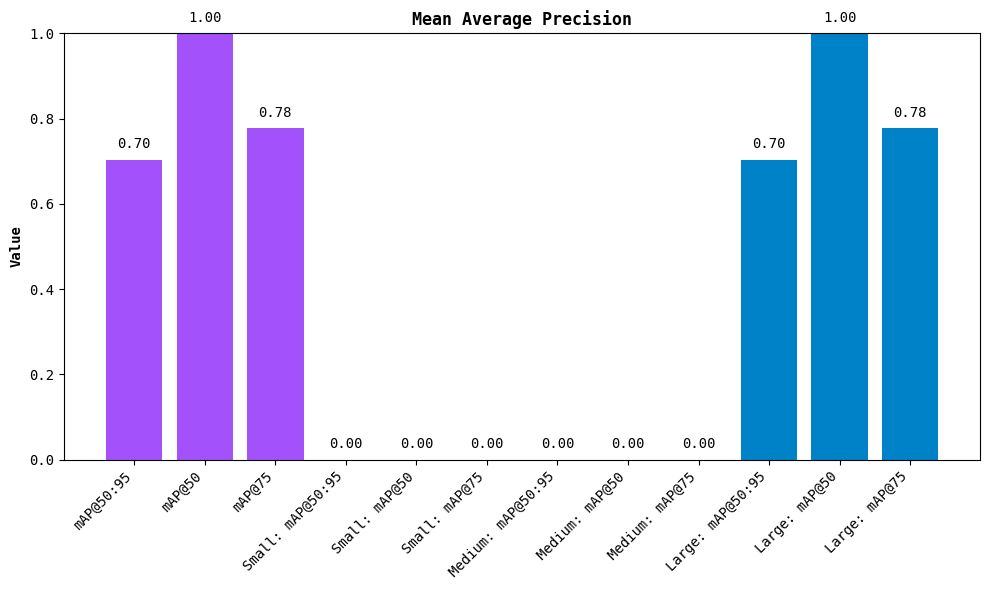

In [18]:
map.plot()

📈 Tes métriques actuelles
Metric	Score	Analyse rapide
mAP@50	0.99 ✅	Excellent → ton modèle détecte bien les objets cibles avec une bonne couverture générale.

mAP@75	0.777 ✅	Bon → ton modèle génère des boîtes bien ajustées dans une majorité de cas.

mAP@50:95	0.703 ✅	Correct à bon → ton modèle reste précis sur plusieurs seuils IoU, ce qui indique une généralisation correcte mais encore améliorable.

🧠 Ce que ça signifie concrètement
📦 Ton modèle repère efficacement les objets, même s’il reste quelques erreurs sur les contours ou dans des cas difficiles.

🧠 Il généralise bien, donc il est probablement apte à détecter des objets sur des images encore jamais vues (même domaine).

🔍 L’amélioration par rapport à avant (0.40 → 0.57 en mAP50:95) montre que tes récents changements sont efficaces.





## Run inference with fine-tuned YOLO model

In [19]:
import supervision as sv

model = YOLO(f'/home/jovyan/yolo-training/train19/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

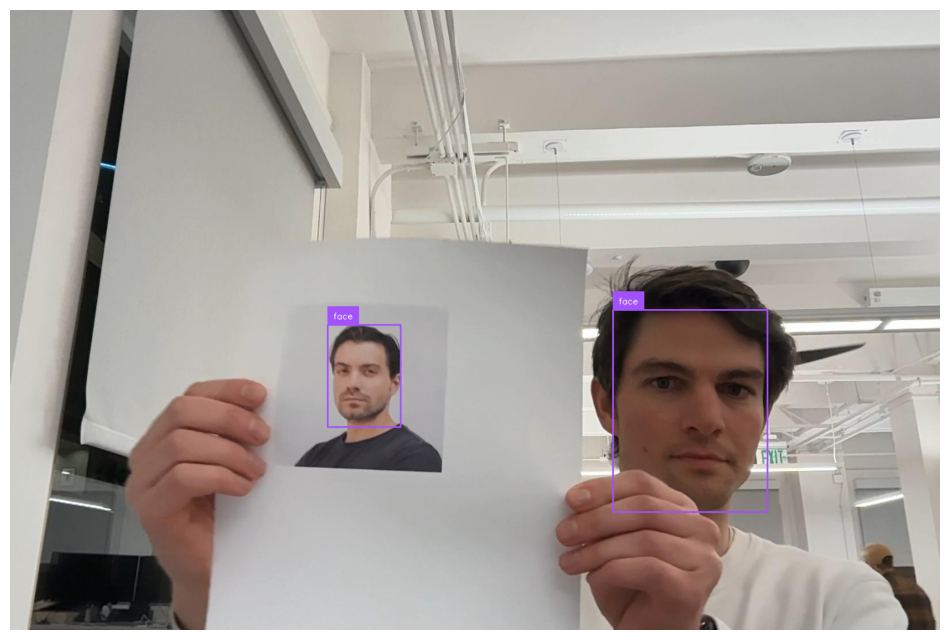

In [24]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

--2025-06-29 14:03:07--  https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg [following]
--2025-06-29 14:03:07--  https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg [following]
--2025-06-29 14:03:07--  https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (

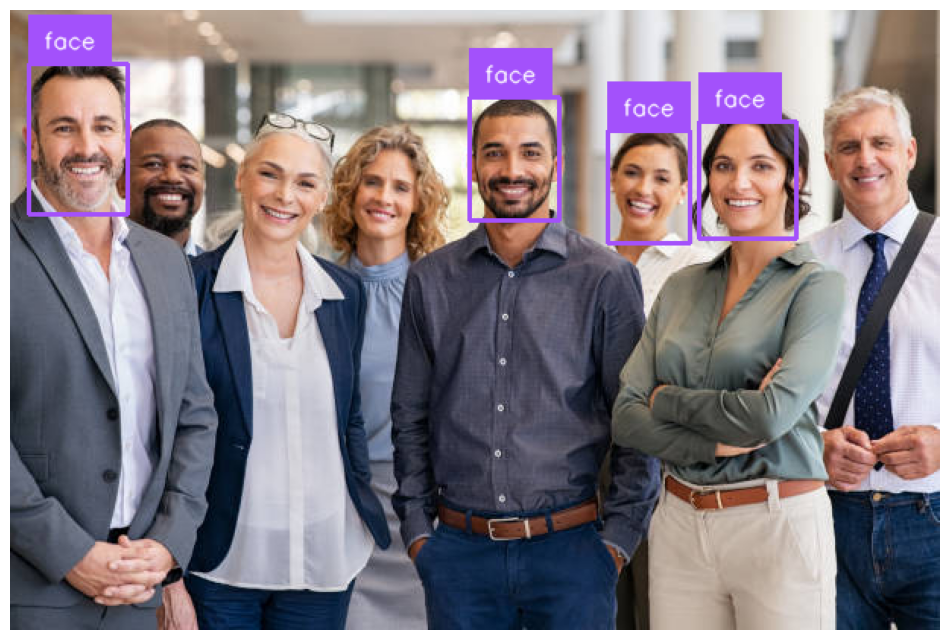

In [26]:
model = YOLO(f'/home/jovyan/yolo-training/train19/weights/best.pt')

!wget https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true

image_path = f"{HOME}/example.jpg?raw=true"
image = cv2.imread(image_path)

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)